In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read training data
df_train = pd.read_csv('train_hire_stats.csv')
df_train.shape

(219600, 4)

In [3]:
df_count=pd.DataFrame(df_train[["Hire_count"]])

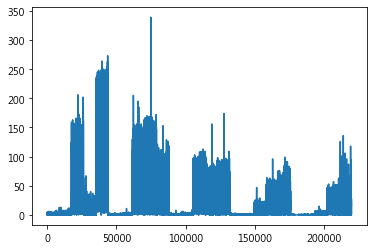

In [4]:
plt.plot(df_count)

In [5]:
#Check weekday & workday
#holidays連假的平常日
#workdays連假的補班日
holidays= {'2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12','2016-02-29', '2016-04-04', '2016-04-05', '2016-06-09', '2016-06-10', 
'2016-09-15', '2016-09-16', '2016-10-10', '2017-01-02', '2017-01-27', '2017-01-30', '2017-02-01','2017-02-27', '2017-02-28'}
makeupworkdays = {'2016-06-04', '2016-09-10', '2017-02-18'}
#malfunctiondays = {'2016-02-05', '2016-02-16'}
malfunctiondays = {'2016-02-05', '2016-02-16', '2016-03-06', '2016-05-2', '2016-07-08', '2016-08-12', '2016-08-15', '2016-09-27', '2016-09-28'}

In [6]:
len(df_train)

219600

In [7]:
df_train.head()

,Zone_ID,Date,Hour_slot,Hire_count
0,1,2016-02-01,0,0
1,1,2016-02-01,1,0
2,1,2016-02-01,2,0
3,1,2016-02-01,3,0
4,1,2016-02-01,4,0


In [8]:
#Declare weekday & workday
isworkday = np.ones((len(df_train),), dtype=int)
weekday = np.ones((len(df_train),), dtype=int)
malday = np.zeros((len(df_train),), dtype=int)

In [9]:
from datetime import datetime
from datetime import timedelta

for index, row in df_train.iterrows():
    dd=datetime.strptime(row['Date'], "%Y-%m-%d")
    hh = int(row['Hour_slot'])
    if hh < 8:
      dd = dd - timedelta(days=1)
    thedaystr =  dd.strftime("%Y-%m-%d")
    if thedaystr in holidays:
        isworkday[index] = 0
    else:
        weekday[index]= dd.weekday() 
        if weekday[index] >=5 and thedaystr not in makeupworkdays:
            isworkday[index] = 0
    if thedaystr in malfunctiondays:
      malday[index] = 1


In [10]:
#Build a new dataframe from the training data
RawX = pd.DataFrame(df_train[["Zone_ID", "Hour_slot"]])
RawX['isworkday'] = isworkday
RawX['weekday'] = weekday
RawX['malday'] = malday

In [11]:
#Resize y into (0,1)
y = df_train["Hire_count"].values/339.0
y.shape

(219600,)

In [12]:
y = y[RawX['malday']==0]
y.shape

(214800,)

In [13]:
RawX = RawX[RawX['malday']==0]
RawX.shape

(214800, 5)

In [14]:
#See the raw input data
RawX.head()

,Zone_ID,Hour_slot,isworkday,weekday,malday
0,1,0,0,6,0
1,1,1,0,6,0
2,1,2,0,6,0
3,1,3,0,6,0
4,1,4,0,6,0


In [15]:
#Use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [16]:
#Build encoder
enc.fit_transform(RawX)
enc.categories_

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23], dtype=int64),
 array([0, 1]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0])]

In [17]:
#Transform data into one hot vector
X = enc.transform(RawX).toarray()
X.shape

(214800, 59)

In [18]:
#See the cooked input data
X[0:3, :]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout

In [20]:
# create and fit a Baseline Neural Network Model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=59))
model.add(Dense(units=10, activation='softmax'))
model.add(Dropout(0.1))
model.add(Dense(1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=100, batch_size=1024, verbose=1)

Epoch 1/100
214800/214800 [==============================] - 7s 31us/sample - loss: 0.0034
Epoch 2/100
214800/214800 [==============================] - 2s 7us/sample - loss: 8.8965e-04
Epoch 3/100
214800/214800 [==============================] - 1s 6us/sample - loss: 7.0491e-04
Epoch 4/100
214800/214800 [==============================] - 1s 6us/sample - loss: 6.4495e-04
Epoch 5/100
214800/214800 [==============================] - 1s 6us/sample - loss: 6.2651e-04
Epoch 6/100
214800/214800 [==============================] - 1s 6us/sample - loss: 6.1134e-04
Epoch 7/100
214800/214800 [==============================] - 1s 6us/sample - loss: 6.1619e-04
Epoch 8/100
214800/214800 [==============================] - 1s 6us/sample - loss: 5.8974e-04
Epoch 9/100
214800/214800 [==============================] - 1s 7us/sample - loss: 5.8705e-04
Epoch 10/100
214800/214800 [==============================] - 1s 6us/sample - loss: 5.7353e-04
Epoch 11/100
214800/214800 [==============================] - 

KeyboardInterrupt: 

In [ ]:
df_test = pd.read_csv('test_hire_stats.csv')
df_test.shape

In [ ]:
#Declare weekday & workday
isworkday2 = np.ones((len(df_test),), dtype=int)
weekday2 = np.ones((len(df_test),), dtype=int)

In [ ]:
for index, row in df_test.iterrows():
    if row['Date'] in holidays:
        isworkday2[index] = 0
    else:
        dd=datetime.strptime(row['Date'], "%Y/%m/%d")
        weekday2[index]= dd.weekday() 
        if weekday2[index] >=5 and row['Date'] not in makeupworkdays:
            isworkday2[index] = 0

In [ ]:
Test = pd.DataFrame(df_test[["Zone_ID", "Hour_slot"]])
Test['isworkday'] = isworkday2
Test['weekday'] = weekday2

In [ ]:
Xtest = enc.transform(Test).toarray()
Xtest.shape

In [ ]:
yt = model.predict(Xtest)*339.0

In [ ]:
plt.plot(yt)

In [ ]:
dfOut = pd.DataFrame(yt)

In [ ]:
dfOut.to_csv('Result.csv')